In [283]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import numpy as np
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [25]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
  
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


Creating a function that will be used to split data into train/dev/test in order to measure the performance of the neural network model

In [52]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)a
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [59]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [60]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [61]:
for p in parameters:
  p.requires_grad = True

In [62]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [63]:
lri = []
lossi = []
stepi = []

In [64]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

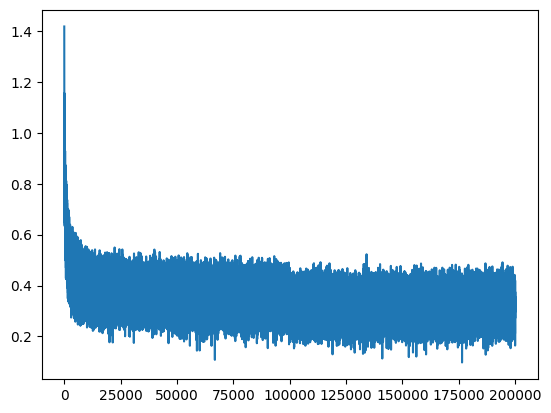

In [66]:
plt.plot(stepi, lossi)

In [67]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1104, grad_fn=<NllLossBackward0>)

This loss is much better than the loss we have from biagram model

In [68]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
ambrilli.
kimleige.
tykhnanden.
jazheen.
deliah.
jarquiu.
ramara.
chaily.
kaleigh.
ham.
porriquinn.
shon.
raiviani.
watelogiearyxin.
kael.
durabee.
deco.
abetteley.
frana.


# Exercise

Trying to beat Andrej's min 2.2 loss from the lecture

In [613]:
embedding_count = 20
layer_size = 200
batch_size = 64
epochs = 60
block_size = 4 # context length: how many characters do we take to predict the next one?

In [614]:
# build the dataset
def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182512, 4]) torch.Size([182512])
torch.Size([22860, 4]) torch.Size([22860])
torch.Size([22774, 4]) torch.Size([22774])


In [615]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, embedding_count), generator=g) # (len(chars), embedding count)
W1 = torch.randn((embedding_count*block_size, layer_size), generator=g) # (embedding count x context size, neuron count)
b1 = torch.randn(layer_size, generator=g) # neuron count
W2 = torch.randn((layer_size, 27), generator=g) # (neuron count, len(chars))
b2 = torch.randn(27, generator=g) # len(chars)
parameters = [C, W1, b1, W2, b2]

In [616]:
for p in parameters:
  p.requires_grad = True

In [617]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [618]:
lri = []
lossi = []
stepi = []

In [619]:
def create_batches(count, batch_size=32):
    indexes = np.arange(count)
    np.random.shuffle(indexes)
    full_batch_count = int(count/batch_size)
    batches = indexes[:full_batch_count*batch_size].reshape(-1, batch_size).tolist()
    if count % batch_size != 0:
        rest = indexes[full_batch_count*batch_size:].tolist()
        missing = batch_size - len(rest)
        rest.extend(np.random.choice(np.arange(count), size=missing, replace=False))
        batches.append(rest)
    return batches

In [620]:
batches = create_batches(Xtr.shape[0], batch_size)
len(batches[-1])

64

In [621]:
lr = 0.1

for epoch in range(epochs):
    epoch_loss = []

    if epoch < 25:
        lr = 0.1
    else:
        lr = 0.02
            
    for batch in batches:
        emb = C[Xtr[batch]] # (32, 3, embedding count)
        h = torch.tanh(emb.view(-1, embedding_count*block_size) @ W1 + b1) # (32, layer_size)
        logits = h @ W2 + b2 # (32, 27)
        loss = F.cross_entropy(logits, Ytr[batch])

        for p in parameters:
            p.grad = None
        loss.backward()

        for p in parameters:
            p.data += -lr * p.grad

        epoch_loss.append(loss.item())

    print(f'Epoch: {epoch}, Loss: {np.mean(epoch_loss):.2f}')

Epoch: 0, Loss: 4.85
Epoch: 1, Loss: 2.77
Epoch: 2, Loss: 2.50
Epoch: 3, Loss: 2.41
Epoch: 4, Loss: 2.37
Epoch: 5, Loss: 2.34
Epoch: 6, Loss: 2.33
Epoch: 7, Loss: 2.31
Epoch: 8, Loss: 2.30
Epoch: 9, Loss: 2.29
Epoch: 10, Loss: 2.28
Epoch: 11, Loss: 2.27
Epoch: 12, Loss: 2.26
Epoch: 13, Loss: 2.26
Epoch: 14, Loss: 2.25
Epoch: 15, Loss: 2.25
Epoch: 16, Loss: 2.24
Epoch: 17, Loss: 2.24
Epoch: 18, Loss: 2.23
Epoch: 19, Loss: 2.23
Epoch: 20, Loss: 2.22
Epoch: 21, Loss: 2.22
Epoch: 22, Loss: 2.22
Epoch: 23, Loss: 2.21
Epoch: 24, Loss: 2.21
Epoch: 25, Loss: 2.13
Epoch: 26, Loss: 2.13
Epoch: 27, Loss: 2.13
Epoch: 28, Loss: 2.12
Epoch: 29, Loss: 2.12
Epoch: 30, Loss: 2.12
Epoch: 31, Loss: 2.12
Epoch: 32, Loss: 2.12
Epoch: 33, Loss: 2.12
Epoch: 34, Loss: 2.12
Epoch: 35, Loss: 2.12
Epoch: 36, Loss: 2.12
Epoch: 37, Loss: 2.12
Epoch: 38, Loss: 2.12
Epoch: 39, Loss: 2.12
Epoch: 40, Loss: 2.12
Epoch: 41, Loss: 2.12
Epoch: 42, Loss: 2.12
Epoch: 43, Loss: 2.12
Epoch: 44, Loss: 2.11
Epoch: 45, Loss: 2.1

In [622]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, embedding_count*block_size) @ W1 + b1) 
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1511, grad_fn=<NllLossBackward0>)

best = 2.15

In [623]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmaveah.
jhavih.
jarie.
thaydence.
saejarone.
fapelync.
kaqui.
neloni.
jcepiivon.
leinah.
lugeris.
quint.
shoveri.
jadbi.
waverox.
jarysi.
frankiigsabeem.
ediia.
giley.
yura.
